# Advanced Generative Chatbot Design

Rene Ortiz, Vivian Perng, Karthik Raghavan

## Project Overview

- Goal: Build a chatbot that can carry out multi-turn conversations, adapt to context, and handle a variety of topics.
- Output: A web or app interface where users can converse with the chatbot.


In [1]:
### COMMENT OUT IF NOT USING GOOGLE COLAB ####
import os
from google.colab import drive
drive.mount('/content/drive')

# Set the path to project folder
project_folder = '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project'

# Change the working directory to project folder
os.chdir(project_folder)

# Check the current working directory
print(os.getcwd())

# Install packages that are not on Google Colab here
!pip install datasets
!pip install evaluate
!pip install rouge_score
!pip install transformers datasets torch

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Chatbot_Project
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e9f1b650a17bc8a0e7e3a1c68fc4975506a67163245e880c7b88caf545b63fa5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
# Import libraries
import json
import numpy as np
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import T5TokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments
from transformers import DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from evaluate import load
import matplotlib.pyplot as plt
import nltk
import spacy
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


## Data Collection and Preprocessing

First, some exploration was done to determine the nested structure in the JSON file for the SQuAD dataset. Once the record path was determined, a function was created that converts a JSON file from the SQuAD dataset format into a structured Pandas DataFrame. The function reads the JSON data, normalizes nested structures, and extracts relevant information like questions, answers, and contexts into a tabular format.

The Pandas DataFrame, will contain columns like id, question, context, answer_start, and answers. It simplifies the process of working with SQuAD data for further analysis or fine-tuned training models by providing a structured, tabular format. Furthermore, another feature was added and integrated into the dataframe: the end of each answer.

In [ ]:
# Open files for reading
with open('/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/train-v1.1.json', 'r') as file:
    train_data = json.load(file)
print(type(train_data))

<class 'dict'>


In [ ]:
# Determine type for each key
for key in train_data.keys():
    print(f'Type of value for key "{key}": {type(train_data[key])}')

# Print information about each key
for key in train_data.keys():
    value = train_data[key]
    if isinstance(value, list):
        print(f'Length of list for key "{key}": {len(value)}')
    else:
        print(f'Value for key "{key}": {value}')

Type of value for key "data": <class 'list'>
Type of value for key "version": <class 'str'>
Length of list for key "data": 442
Value for key "version": 1.1


In [ ]:
def explore_record_path(data, path=None):
    """
    Recursively explore the nested structure of a JSON-like object (dict or list) and print the paths
    and types at each level.

    Parameters:
    data (dict or list): The JSON data or a nested structure to explore.
    path (list): A list to track the current record path (used internally for recursion).
    """

    if path is None:
        path = []

    # If the data is a dictionary, print the keys and recursively explore
    if isinstance(data, dict):
        for key in data:
            print(f"{' > '.join(path + [key])}: {type(data[key])}")
            explore_record_path(data[key], path + [key])

    # If the data is a list, print the index and recursively explore the first element
    elif isinstance(data, list) and len(data) > 0:
        print(f"{' > '.join(path)}[]: {type(data[0])}")
        explore_record_path(data[0], path)

# Explore the nested JSON structure to determine record path
explore_record_path(train_data['data'])

[]: <class 'dict'>
title: <class 'str'>
paragraphs: <class 'list'>
paragraphs[]: <class 'dict'>
paragraphs > context: <class 'str'>
paragraphs > qas: <class 'list'>
paragraphs > qas[]: <class 'dict'>
paragraphs > qas > answers: <class 'list'>
paragraphs > qas > answers[]: <class 'dict'>
paragraphs > qas > answers > answer_start: <class 'int'>
paragraphs > qas > answers > text: <class 'str'>
paragraphs > qas > question: <class 'str'>
paragraphs > qas > id: <class 'str'>


In [ ]:
def squad1_json_to_dataframe(file_path, record_path):
    """
    Function to convert the dataset JSON file to a Pandas DataFrame.

    file_path (str): Path to the JSON file
    record_path (list): Path to the deepest level in the JSON structure

    Returns dataFrame containing the parsed data.
    """
    # Load JSON data
    with open(file_path, 'r') as f:
        file_data = json.load(f)

    # Extract and normalize the nested JSON structures
    answers_df = pd.json_normalize(file_data, record_path)
    questions_df = pd.json_normalize(file_data, record_path[:-1])
    paragraphs_df = pd.json_normalize(file_data, record_path[:-2])

    # Add 'answer start' and 'text' from answers_df to questions_df
    questions_df['answer_start'] = answers_df['answer_start']
    questions_df['answers'] = answers_df['text']

    # Create 'context' by repeating the corresponding paragraph for each question
    questions_df['context'] = np.repeat(paragraphs_df['context'].values, paragraphs_df.qas.str.len())

    # Create final DataFrame with necessary columns
    data = questions_df[['id', 'question', 'context', 'answer_start', 'answers']].copy()

    # Add 'c_id' to uniquely identify each context
    data['c_id'] = pd.factorize(data['context'])[0]

    return data.reset_index(drop=True)


In [ ]:
# loading the data
file_path = '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/train-v1.1.json'
df = squad1_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers'])
df

,id,question,context,answer_start,answers,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0
...,...,...,...,...,...,...
87594,5735d259012e2f140011a09d,In what US state did Kathmandu first establish...,"Kathmandu Metropolitan City (KMC), in order to...",229,Oregon,18890
87595,5735d259012e2f140011a09e,What was Yangon previously known as?,"Kathmandu Metropolitan City (KMC), in order to...",414,Rangoon,18890
87596,5735d259012e2f140011a09f,With what Belorussian city does Kathmandu have...,"Kathmandu Metropolitan City (KMC), in order to...",476,Minsk,18890
87597,5735d259012e2f140011a0a0,In what year did Kathmandu create its initial ...,"Kathmandu Metropolitan City (KMC), in order to...",199,1975,18890


In [ ]:
def add_end_position(start_ix, answer):
  """
  This function determines the end position of each answer
  """
  start_position = start_ix
  end_position = start_position + len(answer)
  return end_position

In [ ]:
# add end positions to the dataset
df['answer_end'] = df.apply(lambda x: add_end_position(x['answer_start'], x['answers']), axis=1)
df.head()

,id,question,context,answer_start,answers,c_id,answer_end
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0,541
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0,213
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0,296
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0,420
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0,126


In [ ]:
# Display 5 random samples and their first answer
sampled_answers = df.sample(5).apply(lambda row: row['answers'], axis=1)

# Print the sampled answers
print(sampled_answers)

9093                         inversely
85426                  divine guidance
28777                     Northumbrian
59317    to perform split transactions
2184            the Karma Kagyu school
dtype: object


In [ ]:
print(type(df['answers'][0]))  # Check the type of the first entry in the 'answers' column



<class 'str'>


In [ ]:
print(df['question'][123])
print(df['context'][123])
print(df['answers'][123])

What type of educational institute is Hesburgh given credit for creating at Notre Dame?
Hesburgh is also credited with transforming the face of Notre Dame by making it a coeducational institution. In the mid-1960s Notre Dame and Saint Mary's College developed a co-exchange program whereby several hundred students took classes not offered at their home institution, an arrangement that added undergraduate women to a campus that already had a few women in the graduate schools. After extensive debate, merging with St. Mary's was rejected, primarily because of the differential in faculty qualifications and pay scales. "In American college education," explained the Rev. Charles E. Sheedy, C.S.C., Notre Dame's Dean of Arts and Letters, "certain features formerly considered advantageous and enviable are now seen as anachronistic and out of place.... In this environment of diversity, the integration of the sexes is a normal and expected aspect, replacing separatism." Thomas Blantz, C.S.C., Notr

## Data Exploration

Transformer-based language models (like BERT and GPT2), do not require tokenization and lemmatization as pre-processing steps because it has its own tokenization mechanism and is designed to work directly with raw text input.

However, for the dataset exploration and word clouds, tokenization is lemma is applied to the answers and questions features to get a visualization of words in the dataset.

In [ ]:
# Download the stopwords from nltk
nltk.download('stopwords')

# Load English stop words and the spaCy model
stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')

# Define a function to preprocess the text: remove stop words and lemmatize
def remove_stopwords_and_lemmatize(text):
    # Process the text using spaCy
    doc = nlp(text)
    # Lemmatize and remove stop words
    lemmatized = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
    return ' '.join(lemmatized)

# Apply the function to the 'narrative' column to create a new cleaned column
df['question_cleaned'] = df['question'].apply(remove_stopwords_and_lemmatize)

# Check the result by printing the first few rows
print(df[['question', 'question_cleaned']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                            question  \
0  To whom did the Virgin Mary allegedly appear i...   
1  What is in front of the Notre Dame Main Building?   
2  The Basilica of the Sacred heart at Notre Dame...   
3                  What is the Grotto at Notre Dame?   
4  What sits on top of the Main Building at Notre...   

                                    question_cleaned  
0        Virgin Mary allegedly appear Lourdes France  
1                     front Notre Dame Main Building  
2  Basilica sacred heart Notre Dame beside structure  
3                                  Grotto Notre Dame  
4                   sit top Main Building Notre Dame  


In [ ]:
# Apply the function to the 'narrative' column to create a new cleaned column
df['context_cleaned'] = df['context'].apply(remove_stopwords_and_lemmatize)

Word clouds of questions and answers from the SQuAD dataset provide us a visual overview of the dataset’s vocabulary, common topics, and themes. They can reveal the types of questions frequently asked, the focus on specific subjects or entities, and any potential bias or redundancy in the dataset.

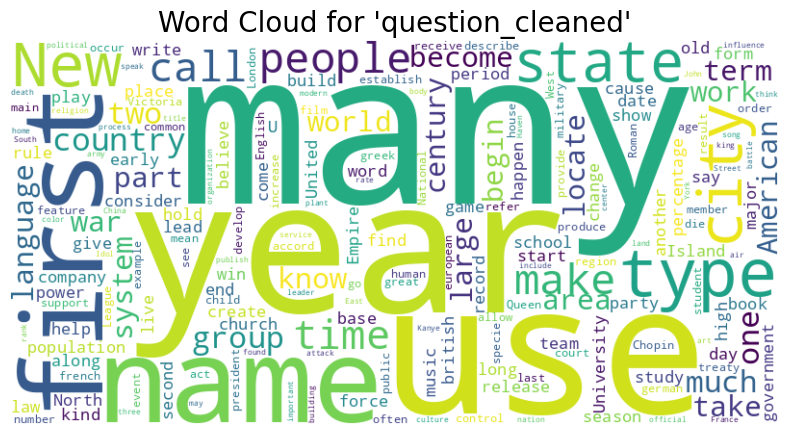

In [ ]:
# Join all text in 'question_cleaned' into a single string
all_text = ' '.join(df['question_cleaned'])

# Create and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 'question_cleaned'", fontsize=20)
plt.show()


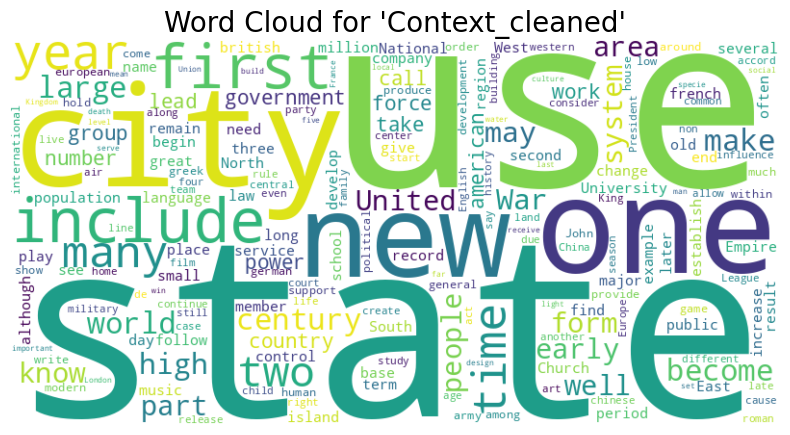

In [ ]:
# Join all text in 'context_cleaned' into a single string
all_text = ' '.join(df['context_cleaned'])

# Create and generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for 'Context_cleaned'", fontsize=20)
plt.show()


In [ ]:
# Function to get the top 10 most frequent words
def get_top_n_words(column, n=10):
    # Join all text entries into a single string
    all_text = ' '.join(column)

    # Tokenize and count word frequencies
    word_freq = Counter(all_text.split())

    # Get the top n most common words
    top_n_words = word_freq.most_common(n)
    return dict(top_n_words)

# Get top 10 words from 'question_cleaned' and 'context_cleaned'
top_10_question_words = get_top_n_words(df['question_cleaned'], n=10)
top_10_context_words = get_top_n_words(df['context_cleaned'], n=10)

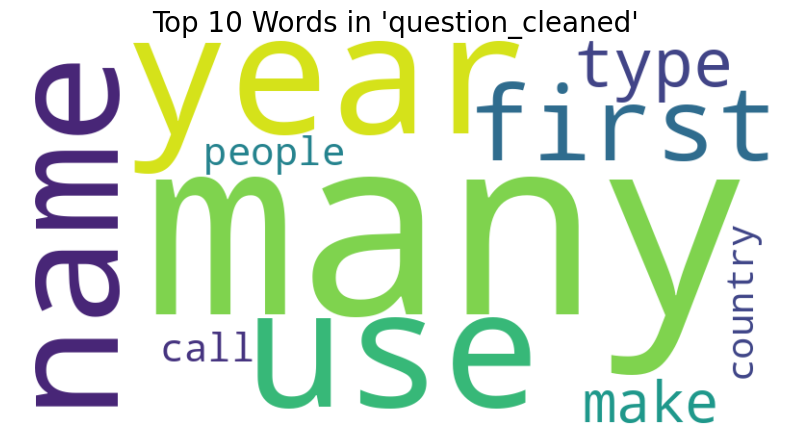

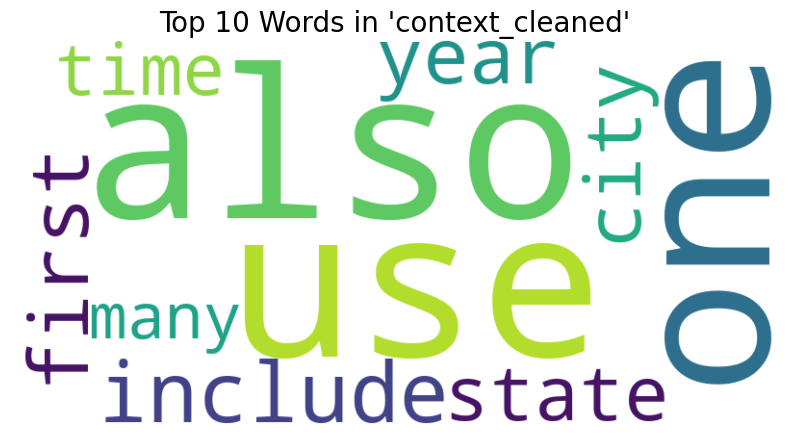

In [ ]:
# Function to generate word cloud from a word frequency dictionary
def plot_wordcloud(word_freq_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Generate word clouds for both columns
plot_wordcloud(top_10_question_words, "Top 10 Words in 'question_cleaned'")
plot_wordcloud(top_10_context_words, "Top 10 Words in 'context_cleaned'")

In [ ]:
# Initialize tokenizer for Flan-T5-Base
tokenizer = T5TokenizerFast.from_pretrained('google/flan-t5-base')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def count_tokens(text, tokenizer):
    """
    This function counts the number of tokens in the specified text column of a
    DataFrame using the given tokenizer, and prints the maximum number of tokens
    found in that column.

    Args:
        df: DataFrame containing the text data.
        text (str): Name of column in df that contains the text to be tokenized.
        tokenizer: A tokenizer from the Hugging Face Transformers library.
    """

    df[f'tokens_{text}'] = df[text].apply(lambda x: len(tokenizer.tokenize(x)))

    # Find the maximum number of tokens in the context column
    max_tokens = df[f'tokens_{text}'].max()

    print(f"The maximum number of tokens in the {text} column is: {max_tokens}")

count_tokens('context', tokenizer)
count_tokens('question', tokenizer)
count_tokens('answers', tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


The maximum number of tokens in the context column is: 967
The maximum number of tokens in the question column is: 66
The maximum number of tokens in the answers column is: 75


## Model Approach 1 - T5

### Text Preprocessing - T5

For the T5 model, the maximum number of tokens for an input sequence is 512 tokens. This constraint posed a challenge as there are context passages in the dataset that exceed this limit; the maximum token length for context was 967 tokens. Truncating the context could potentially lead to information loss. Therefore, a function was designed to dynamically truncate lengthy contexts while preserving the essential information surrounding the answer span. This involved identifying the token positions of the answer within the context and extracting a window of tokens around it, ensuring the answer remained within the truncated sequence. I tried this method instead of a sliding window to reduce computational costs while training. Then, the text was tokenized in the input format "question: [question text] context: context text]."

In [ ]:
def chunk_context(question_tokenized, context_tokenized, answer_start, answer_end, tokenizer, max_length=510):
    """
    This function extracts a chunk of the context around the answer, while
    ensuring that the total length of the tokenized question and context stays
    within a specified maximum length.

    Args:
        question_tokenized (dict): Tokenized question
        context_tokenized (dict): Tokenized context
        answer_start (int): Start character position of answer in the context
        answer_end (int): End character position of answer in the context
        tokenizer: Tokenizer to decode the tokenized context.
        max_length (int): Max length for tokenized sequence of question/context

    Returns:
        str: Context chunk that includes the answer and surrounding context
    """

    input_ids = context_tokenized['input_ids']
    offsets = context_tokenized['offset_mapping']

    # Find token-level start and end positions of the answer
    token_start_position = next(idx for idx, offset in enumerate(offsets) if offset[0] >= answer_start)
    token_end_position = next(idx for idx, offset in enumerate(offsets) if offset[1] >= answer_end)

    # Calculate available space for context (subtracting question length)
    available_context_length = max_length - len(question_tokenized['input_ids'])

    # Determine how much context to keep around the answer
    half_window_size = (available_context_length - (token_end_position - token_start_position)) // 2
    start_window = max(token_start_position - half_window_size, 0)
    end_window = min(token_end_position + half_window_size, len(input_ids))

    # Extract the relevant context chunk
    truncated_input_ids = input_ids[start_window:end_window]
    truncated_context = tokenizer.decode(truncated_input_ids, skip_special_tokens=True)

    return truncated_context


In [ ]:
def preprocess_function(df, tokenizer, max_length=510):
    """
    Preprocesses a DataFrame containing questions, context, and answers for
    input into a transformer model. This function handles the tokenization of
    questions and contexts, and if the combined length exceeds a given max
    length, it truncates the context using a chunking mechanism that ensures
    the answer remains in the context.

    Args:
        df: DataFrame
        tokenizer: A tokenizer from the Hugging Face Transformers library.
        max_length (int): Max length for tokenized sequence of question/context

    Returns:
        dict: Dictionary containing tokenized inputs and labels
    """

    inputs = []

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        question = row['question']
        context = row['context']
        answer_start = row['answer_start']
        answer_text = row['answers']
        answer_end = row['answer_end']

        # Tokenize the question and context, both with their respective prefixes
        question_tokenized = tokenizer(question, truncation=False)
        context_tokenized = tokenizer(context, return_offsets_mapping=True, truncation=False)
        total_length = len(question_tokenized['input_ids']) + len(context_tokenized['input_ids'])

        if total_length > max_length:
            # Call chunk_context to truncate context while retaining the answer
            truncated_context = chunk_context(question_tokenized, context_tokenized, answer_start, answer_end, tokenizer, max_length)
        else:
            truncated_context = context

        # Create the final input with both prefixes
        input_text = f"question: {question} context: {truncated_context}"
        inputs.append(input_text)

    # Tokenize the inputs w/o padding, which will be handled by Data Collator
    model_inputs = tokenizer(inputs, truncation=True, padding="do_not_pad")

    # Tokenize the target answers (labels)
    labels = tokenizer([row['answers'] for _, row in df.iterrows()], max_length=75, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [ ]:
# Apply preprocessing to train and validation datasets
tokenized_squad = preprocess_function(df, tokenizer, max_length=510)

In [ ]:
# Save tokenizer
tokenizer.save_pretrained("./T5_tokenizer")

('./T5_tokenizer/tokenizer_config.json',
 './T5_tokenizer/special_tokens_map.json',
 './T5_tokenizer/spiece.model',
 './T5_tokenizer/added_tokens.json',
 './T5_tokenizer/tokenizer.json')

In [ ]:
# Convert the tokenized data to a Hugging Face Dataset
tokenized_dataset = Dataset.from_dict({
    "input_ids": tokenized_squad["input_ids"],
    "attention_mask": tokenized_squad["attention_mask"],
    "labels": tokenized_squad["labels"]
})

In [ ]:
# Split tokenized Hugging Face Datset into train and validation sets
train_val_split = tokenized_dataset.train_test_split(test_size=0.3)

# Create dataset dictionary to handle both train and validation sets
dataset_t5 = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test']
})

### Model Design and Training - T5

One of the model architectures that we explored is based on the T5 (Text-To-Text Transfer Transformer) framework. Specifically, it utilizes the T5forConditionalGeneration class from Hugging Face’s Transformers library, which supports sequence-to-sequence tasks. The model is fine-tuned to handle question-answering tasks by taking both the question and context as input. The model is trained and evaluated using Hugging Face’s Trainer API, enabling easy integration of training arguments and a data collator for efficient batching. Hyperparameters were chosen to minimize training times.


In [ ]:
# Load the pre-trained Flan-T5-Base model
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./flan-t5-finetuned-squad',  # Directory for saved checkpoints
    per_device_train_batch_size=16, # Chosen for optimal memory usage and speed
    per_device_eval_batch_size=16, # Chosen for optimal memory usage and speed
    num_train_epochs=3,  # Number of epochs for training
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    save_steps=10_000,  # Save checkpoint every 10k steps
    save_total_limit=2,  # Only keep the last 2 checkpoints
    learning_rate=3e-5, # Low learning rate for pre-trained model
    warmup_steps=500,  # Warmup steps for learning rate scheduling
    weight_decay=0.01,  # Regularization
    logging_dir='./logs',  # Directory for logs
    logging_steps=500,  # Log every 500 steps
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define a data collator for seq2seq tasks
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_t5['train'],
    eval_dataset=dataset_t5['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.025100,0.017799
2,0.021900,0.017643
3,0.019900,0.017729


TrainOutput(global_step=11499, training_loss=0.6960623176608545, metrics={'train_runtime': 5272.5578, 'train_samples_per_second': 34.89, 'train_steps_per_second': 2.181, 'total_flos': 8.613581460277248e+16, 'train_loss': 0.6960623176608545, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained("./flan-t5-finetuned-squad")
tokenizer.save_pretrained("./t5-tokenizer")

('./t5-tokenizer/tokenizer_config.json',
 './t5-tokenizer/special_tokens_map.json',
 './t5-tokenizer/spiece.model',
 './t5-tokenizer/added_tokens.json',
 './t5-tokenizer/tokenizer.json')

### Evaluation - T5

The Flan-T5 model shows consistent improvement in the training loss across epochs, indicating that it is learning effectively during fine-tuning. The training loss decreased from 0.0251 in the first epoch to 0.0199 by the third epoch. Meanwhile, the validation loss started at 0.017799 in the first epoch and gradually reduced to 0.017643 in the second epoch, but slightly increased to 0.017729 in the third epoch. This suggests that while the model is improving its ability to minimize errors during training, the validation performance has begun to plateau after the second epoch.


In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.01772897131741047,
 'eval_runtime': 207.4769,
 'eval_samples_per_second': 126.665,
 'eval_steps_per_second': 7.919,
 'epoch': 3.0}

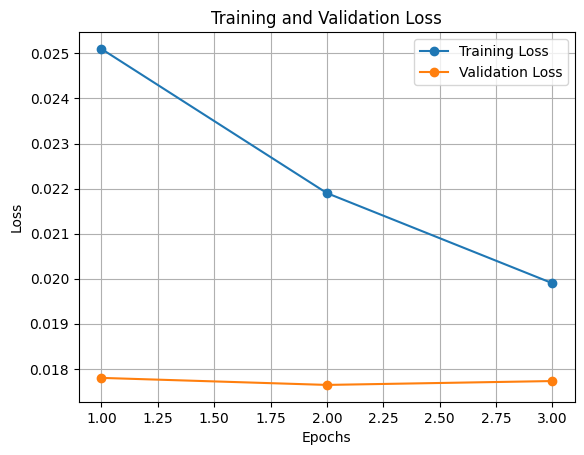

In [ ]:
# Training and validation loss data
epochs = [1, 2, 3]
train_losses = [0.025100, 0.021900, 0.019900]
val_losses = [0.017799, 0.017643, 0.017729]

# Plot the training and validation loss
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Next, the model was used to make predictions and evaluated on the test set. First, I had the model make predictions based off the questions only to see if the model would be capable of making factually accurate generative answers. The BLEU and ROUGE scores were all very low. When the actual answers and predicted answers were compared, I could see that while the predicted answers were semantically plausible, they were factually incorrect.

Then, I tested the model on its extractive capabilities by inputting the question and context when making predictions, which is ultimately how the model was trained. Here, the fine-tuned model demonstrated strong results in generating accurate and contextually relevant responses. The BLEU score of 0.8407 indicates a strong precision in generating correct outputs. The ROUGE-1 score shows that 90.48% of unigrams in the reference answers were also present in the predictions. The ROUGE-2 score shows that 59.43% of bigrams were captured accurately. The ROUGE-L and ROUGE-Lsum scores of 0.9046 and 0.9048, respectively, suggest that the model effectively captures both the longest common subsequences and the overall structure of the reference answers. Printing the actual answers and predicted answers showed that the model did in fact answer the questions accurately. Overall, the model performed decently, but was not the best model out of all the ones we tried

In [ ]:
# Load the dataset, specifying it as the test split
test_dataset = load_dataset('json', data_files={'test': '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/dev-v1.1.json'}, field='data')

# Verify that the dataset loaded correctly
print(test_dataset)

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})


In [ ]:
def preprocess_test_questions(examples):
    """
    This function preprocesses the test dataset by extracting questions from a
    nested structure and preparing them in the "question: [question]" format.
    The resulting questions are then tokenized.

    Args:
        examples: Dictionary containing paragraphs with nested questions.

    Returns:
        dict: Dictionary of tokenized questions suitable for input into model.
    """

    # Extract questions from the nested structure
    questions = []

    # Access the paragraphs field (already a single example)
    for paragraph in examples['paragraphs']:
        # Extract questions from qas inside the paragraph
        for qa in paragraph['qas']:
            questions.append("question: " + qa['question'])

    # Tokenize the questions
    model_inputs = tokenizer(questions, max_length=512, truncation=True, padding="max_length")

    return model_inputs


In [ ]:
# Tokenize the test split of the dataset
tokenized_test_dataset = test_dataset['test'].map(preprocess_test_questions, batched=False, remove_columns=["paragraphs"])


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

In [ ]:
def generate_predictions(tokenized_test_dataset):
    '''
    This function generates predictions for a given tokenized test dataset.

    Parameters:
    tokenized_test_dataset: A tokenized dataset where each example contains
    input_ids and attention masks necessary for model inference.

    Returns:
    predictions (list): A list of decoded predictions generated by the model
    '''

    predictions = []

    # Loop through each example in the tokenized test dataset
    for i in range(len(tokenized_test_dataset)):

        # Access individual example
        example = tokenized_test_dataset[i]

        # If there are multiple sequences, iterate over each sequence
        for seq_index in range(len(example['input_ids'])):
            input_ids = torch.tensor(example['input_ids'][seq_index], dtype=torch.long).unsqueeze(0).to(device)
            attention_mask = torch.tensor(example['attention_mask'][seq_index], dtype=torch.long).unsqueeze(0).to(device)

            # Generate predictions using the model
            outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=100, num_beams=4, early_stopping=True)

            # Decode the predicted output into text
            decoded_pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Append the prediction to the list
            predictions.append(decoded_pred)

    return predictions

In [ ]:
# Generate predictions for the test dataset
predictions = generate_predictions(tokenized_test_dataset)

In [ ]:
# Extract multiple reference answers for each question from the test dataset
references = []

# Loop through the test dataset and collect the reference answers
for example in test_dataset['test']:
    # Loop through paragraphs and then through qas
    for paragraph in example['paragraphs']:
        for qa in paragraph['qas']:
            # Extract all valid answers for the current question
            current_references = [answer['text'] for answer in qa['answers']]
            references.append(current_references)



In [ ]:
# Load BLEU metric
bleu_metric = load("bleu")
rouge_metric = load("rouge")

In [ ]:
# Compute the BLEU score directly on plain text
bleu_results = bleu_metric.compute(predictions=predictions, references=references)
print("BLEU Score:", bleu_results['bleu'])

# Compute the ROUGE score directly on plain text
rouge_results = rouge_metric.compute(predictions=predictions, references=references)
print("ROUGE Scores:", rouge_results)

BLEU Score: 0.02350549896150287
ROUGE Scores: {'rouge1': 0.1045025947615909, 'rouge2': 0.01745895815538697, 'rougeL': 0.10327531290022487, 'rougeLsum': 0.10325487161359242}


In [ ]:
# Number of examples to check
n_examples = 20

# Keep track of index across paragraphs and questions
prediction_idx = 0

# Loop through paragraphs and questions
for paragraph_idx, paragraph in enumerate(test_dataset['test']):
    for qa_idx, qa in enumerate(paragraph['paragraphs'][0]['qas']):

        # Extract the question and context from the test dataset
        question = qa['question']
        context = paragraph['paragraphs'][0]['context']

        # Extract the corresponding prediction and reference answers
        prediction = predictions[prediction_idx]
        reference_answers = references[prediction_idx]

        # Print out the aligned prediction, question, context, and references
        print(f"Example {prediction_idx + 1}:")
        print(f"Question: {question}")
        print(f"Context: {context}")
        print(f"Prediction: {prediction}")
        print(f"Reference Answers: {reference_answers}")
        print("=" * 50)

        # Move to the next prediction
        prediction_idx += 1

        # Stop after the desired number of examples
        if prediction_idx >= n_examples:
            break
    if prediction_idx >= n_examples:
        break


Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Prediction: Dallas Cowboys
Reference Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Example 2:
Question: Which NFL team repr

Next, the model was also evaluated on its predictions when given the question and context.

In [ ]:
def preprocess_test_w_context(examples):
    """
    This function preprocesses the test dataset by extracting questions and
    context from a nested structure and formatting them into the
    "question: [question] context: [context]" format. The resulting inputs are
    then tokenized for model consumption.

    Args:
        examples: Dictionary containing paragraphs with nested questions/context.

    Returns:
        dict: Dictionary of tokenized inputs suitable for input into model.
    """

    # Extract questions and context from the nested structure
    inputs = []

    # Iterate through each paragraph in the examples
    for paragraph in examples['paragraphs']:
        context = paragraph['context']  # Extract the context

        # For each question in the 'qas' field
        for qa in paragraph['qas']:
            question = qa['question']  # Extract the question

            # Prepare the input text in the "question: context:" format
            input_text = f"question: {question} context: {context}"

            # Append the prepared text to the inputs list
            inputs.append(input_text)

    # Tokenize the inputs (questions with context)
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    return model_inputs

In [ ]:
# Preprocess question and context from test dataset
tokenized_test_context = test_dataset['test'].map(preprocess_test_w_context, batched=False, remove_columns=["paragraphs"])

In [ ]:
# Generate predictions given question and context
predictions_context = generate_predictions(tokenized_test_context)

In [ ]:
# Load BLEU metric
bleu_metric = load("bleu")
rouge_metric = load("rouge")

# Compute the BLEU score without manual tokenization
bleu_results = bleu_metric.compute(predictions=predictions_context, references=references)
print("BLEU Score:", bleu_results['bleu'])

# Compute the ROUGE score directly on plain text
rouge_results = rouge_metric.compute(predictions=predictions_context, references=references)
print("ROUGE Scores:", rouge_results)

BLEU Score: 0.8406594745259233
ROUGE Scores: {'rouge1': 0.9047930093457501, 'rouge2': 0.5942539485702308, 'rougeL': 0.9046121033295109, 'rougeLsum': 0.9047614132389385}


In [ ]:
# Number of examples to check
n_examples = 20  # Adjust this based on how many samples you want to check

# Keep track of index across paragraphs and questions
prediction_idx = 0

# Loop through paragraphs and questions
for paragraph_idx, paragraph in enumerate(test_dataset['test']):
    for qa_idx, qa in enumerate(paragraph['paragraphs'][0]['qas']):

        # Extract the question and context from the test dataset
        question = qa['question']
        context = paragraph['paragraphs'][0]['context']

        # Extract the corresponding prediction and reference answers
        prediction = predictions_context[prediction_idx]
        reference_answers = references[prediction_idx]  # This contains multiple references

        # Print out the aligned prediction, question, context, and references
        print(f"Example {prediction_idx + 1}:")
        print(f"Question: {question}")
        print(f"Context: {context}")
        print(f"Prediction: {prediction}")
        print(f"Reference Answers: {reference_answers}")
        print("=" * 50)

        # Move to the next prediction
        prediction_idx += 1

        # Stop after the desired number of examples
        if prediction_idx >= n_examples:
            break
    if prediction_idx >= n_examples:
        break

Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Prediction: Denver Broncos
Reference Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Example 2:
Question: Which NFL team repr

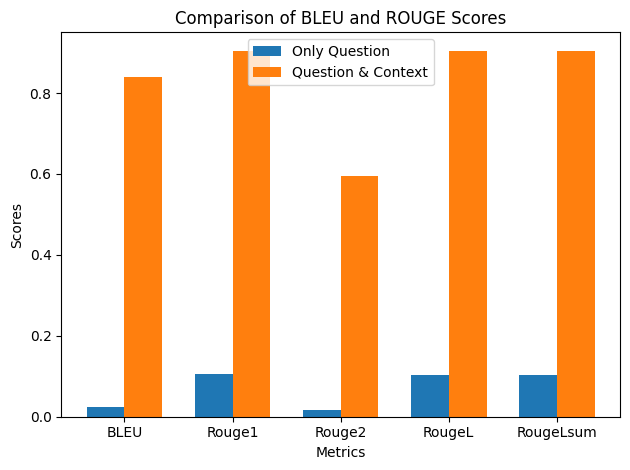

In [ ]:
# Data for plotting
metrics = ["BLEU", "Rouge1", "Rouge2", "RougeL", "RougeLsum"]
question_given_scores_list = [0.02350549896150287, 0.1045025947615909,
                              0.01745895815538697, 0.10327531290022487,
                              0.10325487161359242]
question_context_given_scores_list = [0.8406594745259233, 0.9047930093457501,
                                      0.5942539485702308, 0.9046121033295109,
                                      0.9047614132389385]

# Bar width and position
bar_width = 0.35
index = np.arange(len(metrics))

# Create the bar graph
plt.bar(index, question_given_scores_list, bar_width, label='Only Question')
plt.bar(index + bar_width, question_context_given_scores_list, bar_width, label='Question & Context')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of BLEU and ROUGE Scores')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


## Model Approach 2 - GPT

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model = GPT2LMHeadModel.from_pretrained('gpt2')
# Load GPT-2 tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Set model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

### Text Preprocessing - GPT

This code adds special tokens (<|question|>, <|context|>, <|answer|>, and [PAD]) to the tokenizer to differentiate between question, context, and answer segments. It then resizes the model's token embedding layer to accommodate the expanded vocabulary, allowing the model to understand and process these special segments during training and inference.

In [ ]:
# Add special tokens to differentiate between question and answer
special_tokens_dict = {'pad_token': '[PAD]', 'additional_special_tokens': ['<|question|>', '<|context|>', '<|answer|>']}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(50261, 768)

Next cell code formats the data from a DataFrame into two lists (input_texts and output_texts), where:

input_texts contains strings combining the context and question, marked by special tokens.
output_texts contains strings combining the context and answer, also marked by special tokens.
These formatted text pairs are essential for fine-tuned / training the SQuAD model to generate answers based on the provided context and question. The use of special tokens helps the model distinguish between different parts of the input and output during training.

In [ ]:
# Prepare dataset for training
# Ensure that each question and context are formatted properly
input_texts = df.apply(lambda row: f"<|context|> {row['context']} <|question|> {row['question']}", axis=1).tolist()
output_texts = df.apply(lambda row: f"<|context|> {row['context']} <|answer|> {row['answers'][0] if len(row['answers']) > 0 else ''}", axis=1).tolist()


In [ ]:
# Combine inputs and outputs into a dataset
data_dict = {'input': input_texts, 'output': output_texts}
train_dataset = Dataset.from_dict(data_dict)

In [ ]:
# Define tokenization function for inputs and labels
def tokenize_function(examples):
    inputs = tokenizer(examples['input'], padding="max_length", truncation=True, max_length=512)
    outputs = tokenizer(examples['output'], padding="max_length", truncation=True, max_length=512)

    inputs['labels'] = outputs['input_ids']
    return inputs

# Tokenize the dataset
train_dataset = train_dataset.map(tokenize_function, batched=True, remove_columns=["input", "output"])


Map:   0%|          | 0/87599 [00:00<?, ? examples/s]

### Model Design and Training - GPT

The following training arguments for fine-tuning a GPT-2 model with configurations for output management, batch size, checkpoint saving, logging, and evaluation intervals. It also enables mixed-precision training (fp16) to optimize performance. After trial and errors training with different hyperparameters, these settings were the best to manage the constraints of the training environment (e.g., available memory and GPU time) effectively.

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./gpt2-finetuned-chatbot",
    overwrite_output_dir=True,
    num_train_epochs=3,  # Reduce epochs because training time is an issue
    per_device_train_batch_size=32,  # Adjust batch size as per available memory on Colab
    save_steps=4000,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=3000,
    eval_strategy="steps",  # Evaluate during training
    eval_steps=2000,  # Adjust evaluation steps
    fp16=True,  # Enable mixed precision training to reduce training time (supported by Colab A100 GPU)
)

In [ ]:
# Define evaluation dataset if available (optional)
#eval_dataset = train_dataset.train_test_split(test_size=0.1)['test']  # Split train/test for evaluation
# Split dataset for evaluation
train_test_split = train_dataset.train_test_split(test_size=0.1)
eval_dataset = train_test_split['test']
train_dataset = train_test_split['train']
# Initialize Trainer class for training GPT-2
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Optional evaluation dataset
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
# Train the model
trainer.train()

Step,Training Loss,Validation Loss
2000,No log,0.960767
4000,1.157600,0.910583
6000,0.941900,0.883819


TrainOutput(global_step=7392, training_loss=1.023916516985212, metrics={'train_runtime': 2435.0256, 'train_samples_per_second': 97.131, 'train_steps_per_second': 3.036, 'total_flos': 6.1800007532544e+16, 'train_loss': 1.023916516985212, 'epoch': 3.0})

The GPT-2 model trained for a total of 7,392 steps over 3 epochs, achieving an average training loss of 1.0239. The process took about 40.6 minutes, processing approximately 97 samples per second and completing around 3 steps per second. The total floating-point operations indicate the computational load handled during training. The results suggest that the model learned reasonably well, but there was room for further optimization or fine-tuning.

In [ ]:
# Save the fine-tuned model
# Define the directory where the model and tokenizer will be saved
save_directory = "/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model"

# Save the trained model
model.save_pretrained(save_directory)

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

('/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model/added_tokens.json')

In [ ]:
# ONLY LOAD when testing and not training
import torch


# Define the directory where the model and tokenizer are saved
save_directory = "/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/trained_model"
# Load the saved model
model = GPT2LMHeadModel.from_pretrained(save_directory)

# Load the saved tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(save_directory)

# Set model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model and tokenizer loaded successfully!")

Model and tokenizer loaded successfully!


The generate_response function generates a response based on a given question and context using a fine-tuned GPT-2 model.

The output is decoded, and the function extracts the relevant answer from the generated text, returning it to the caller. This setup is useful for building the question-answering chatbot that rely on context information.

In [ ]:
# Function to generate a response given a question and context
def generate_response(question, context):
    # Combine the context and question into the input format
    input_text = f"<|context|> {context} <|question|> {question}"

    # Encode the input
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    attention_mask = torch.ones(input_ids.shape, device=device)

    # Generate a response
    with torch.no_grad():
        output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=150,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )

    # Decode the output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Look for the <|answer|> token in the generated response and return everything after it
    answer_start = decoded_output.find("<|answer|>") + len("<|answer|>")
    if answer_start >= len("<|answer|>"):
        answer = decoded_output[answer_start:].strip()
    else:
        answer = "No answer token found."

    return answer



Unfortunately, after training, testing and validation were not as good as expected.
My model's evaluation metrics indicate moderate performance, with an evaluation loss of 0.877 indicates some learning progress and a perplexity score of 2.40 showing reasonable confidence in its predictions. However, the BLEU score of 0.0 highlights that the responses do not align with the reference answers, pointing to issues with generating relevant output.

Additionally, the error message "No answer token found" from any question/context submission, demostrates that the model has difficulties in identifying or generating the correct answer token, possibly due to missing special tokens or improper data formatting during training. Overall, it looks like further fine-tuning and data preprocessing are needed to improve the model's accuracy and response quality.

After many unsuccesful training sessions and testing over several days, I decided to move to **distilgpt2** training as an alternative.

In [ ]:
# Evaluate the model using the validation dataset
eval_results = trainer.evaluate(eval_dataset=eval_dataset)

# Print evaluation results (e.g., loss, perplexity)
print(f"Evaluation Loss: {eval_results['eval_loss']}")
perplexity = torch.exp(torch.tensor(eval_results['eval_loss']))
print(f"Perplexity: {perplexity.item()}")

Evaluation Loss: 0.877443790435791
Perplexity: 2.404744863510132


In [ ]:
import evaluate

# Load the BLEU metric
bleu = evaluate.load("bleu")

# Prepare some test examples
references = ["Paris is the capital of France."]
predictions = [generate_response("What is the capital of France?", "France is a country in Europe.")]

# Evaluate the BLEU score
results = bleu.compute(predictions=predictions, references=references)
print(f"BLEU score: {results['bleu']}")


BLEU score: 0.0


In [ ]:
# Example test
context = "The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering,"
question = "How many BS level degrees are offered in the College of Engineering at Notre Dame?"
response = generate_response(question, context)
print(f"Answer: {response}")

Answer: No answer token found.


#2nd approach to training -> ***distilgpt2*** Working!

In [ ]:
!pip install evaluate
!pip install rouge_score
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=18cd440bb487588b616c9a9e9d12d7743eb1ad48718676777aa6d28093c4a08d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
import json
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer
import numpy as np
from evaluate import load
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"


One of the key changes I decided on this approach was to try a simple loop to extract the data from nested JSON structures, avoiding the complexity of JSON normalization and Pandas operations. This clarity reduces the likelihood of errors and simplifies debugging.

In [ ]:
# Load the dataset
with open('/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/dev-v1.1.json', 'r') as _f:
    dev = json.load(_f)

with open('/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/train-v1.1.json', 'r') as _f:
    train = json.load(_f)

# Function to create dataset from JSON data
def createDataset(_data):
    contexts = []
    questions = []
    answers = []

    for i in _data['data']:
        for j in i['paragraphs']:
            context = j['context']
            for k in j['qas']:
                question = k['question']
                for m in k['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(m['text'])

    return Dataset.from_dict({
        'context': contexts,
        'question': questions,
        'answers': answers
    })

I decided to use distilgpt2 instead of gpt2 when I read it offers a balance between performance and efficiency. Since computing resources and time was becoming a challenge, it turned to be an excellent option when looking to reduce training times, optimize GPU memory usage, and maintain strong model performance without the computational overhead of a full gpt2 model.

The hyperparameters were selected to optimize resource usage, maintain model stability, and fine-tune distilgpt2 to the SQuAD dataset efficiently.
Some of the key hyperparameters are:

output_dir='./results' specifies a location to save checkpoints and logs, ensuring model progress is tracked and recoverable.

evaluation_strategy="epoch" evaluates and saves the model at the end of each epoch, providing regular evaluation points and storing model states.

Batch Sizes: A per_device_train_batch_size of 32 was the optimal size to process the training batches on a Colab A100 GPU memory. The smaller evaluation batch size (per_device_eval_batch_size=8) reduces memory usage during evaluation.

Number of Epochs = 3 offers a reasonable duration for fine-tuning without overfitting. It provides enough training cycles for the model to adapt to the dataset while keeping training time manageable.

fp16=True enables mixed-precision training, which improves performance and reduces memory usage on compatible hardware. This allows for larger batch sizes and faster training without exceeding GPU memory limits. I found this very helpful when working with Colab GPU offerinfs.

In [ ]:
# Prepare training and testing datasets
TRAIN = createDataset(train)
TEST = createDataset(dev)

# Split the training dataset for validation
TRAIN = TRAIN.train_test_split(test_size=0.2, seed=4444)

# Load the tokenizer and model
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.gradient_checkpointing_enable()

# Add special tokens
special_tokens_dict = {
    'pad_token': '[PAD]',
    'additional_special_tokens': ['<|context|>', '<|question|>', '<|answer|>']
}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

# Function to preprocess the dataset for training
def preprocess_function(examples):
    inputs = [
        f"<|context|> {context} <|question|> {question} <|answer|> {answer}"
        for context, question, answer in zip(examples['context'], examples['question'], examples['answers'])
    ]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    return model_inputs

# Tokenize the training and testing datasets
train_tokenized = TRAIN.map(preprocess_function, batched=True, remove_columns=TRAIN["train"].column_names)
test_tokenized = TEST.map(preprocess_function, batched=True, remove_columns=TEST.column_names)


training_args = TrainingArguments(
    output_dir='./results',          # Output directory for checkpoints and logs
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model checkpoint at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=32,   # Training batch size
    per_device_eval_batch_size=8,    # Evaluation batch size
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,                # Log every 10 steps
    load_best_model_at_end=True,     # Load the best model when finished
    metric_for_best_model="eval_loss",    # Use BLEU score as the metric to decide the best model
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized["train"],
    eval_dataset=train_tokenized["test"],
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
)
# Train the model
trainer.train()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Map:   0%|          | 0/17520 [00:00<?, ? examples/s]

Map:   0%|          | 0/34726 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Epoch,Training Loss,Validation Loss
1,2.343300,2.225600
2,2.270000,2.179275
3,2.242000,2.163909


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=6570, training_loss=2.396888205703898, metrics={'train_runtime': 964.2743, 'train_samples_per_second': 218.026, 'train_steps_per_second': 6.813, 'total_flos': 1.3733561238552576e+16, 'train_loss': 2.396888205703898, 'epoch': 3.0})

Calculating metrics like ROUGE and BLEU after training provides an objective measure of the model’s performance and reduces training time and resources, which was my intention.

Also, with saved models and recorded metrics, we can compare different versions of the model trained under various conditions (e.g., different hyperparameters or datasets). This helps in identifying which configuration performs best and informs further fine-tuning strategies.

In [ ]:
# Save the model after training
trainer.save_model('./final_model_metrics')

# Save the tokenizer
tokenizer.save_pretrained('./final_model_metrics')


('./final_model_metrics/tokenizer_config.json',
 './final_model_metrics/special_tokens_map.json',
 './final_model_metrics/vocab.json',
 './final_model_metrics/merges.txt',
 './final_model_metrics/added_tokens.json',
 './final_model_metrics/tokenizer.json')

In [ ]:
# CODE CELL TO LOAD MODEL AND TRAINER DEFINITIONS, recreate datasets

from transformers import AutoModelForCausalLM, AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('./final_model')

# Load the model
model = AutoModelForCausalLM.from_pretrained('./final_model')

# Make sure the tokenizer and model are correctly loaded
print("Tokenizer and model loaded successfully.")

# Restore all model definitions
# Prepare training and testing datasets
TRAIN = createDataset(train)
TEST = createDataset(dev)

# Split the training dataset for validation
TRAIN = TRAIN.train_test_split(test_size=0.2, seed=4444)

# Load the tokenizer and model
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.gradient_checkpointing_enable()

# Add special tokens
special_tokens_dict = {
    'pad_token': '[PAD]',
    'additional_special_tokens': ['<|context|>', '<|question|>', '<|answer|>']
}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

# Function to preprocess the dataset for training
def preprocess_function(examples):
    inputs = [
        f"<|context|> {context} <|question|> {question} <|answer|> {answer}"
        for context, question, answer in zip(examples['context'], examples['question'], examples['answers'])
    ]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length")
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    return model_inputs

# Tokenize the training and testing datasets
train_tokenized = TRAIN.map(preprocess_function, batched=True, remove_columns=TRAIN["train"].column_names)
test_tokenized = TEST.map(preprocess_function, batched=True, remove_columns=TEST.column_names)


training_args = TrainingArguments(
    output_dir='./results',          # Output directory for checkpoints and logs
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model checkpoint at the end of each epoch
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=32,   # Training batch size
    per_device_eval_batch_size=8,    # Evaluation batch size
    num_train_epochs=3,              # Number of epochs
    weight_decay=0.01,               # Weight decay
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=100,                # Log every 10 steps
    load_best_model_at_end=True,     # Load the best model when finished
    metric_for_best_model="eval_loss",
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized["train"],
    eval_dataset=train_tokenized["test"],
    tokenizer=tokenizer,
    #compute_metrics=compute_metrics,
)

Tokenizer and model loaded successfully.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/70079 [00:00<?, ? examples/s]

Map:   0%|          | 0/17520 [00:00<?, ? examples/s]

Map:   0%|          | 0/34726 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


The generate_response function takes a context and a question as input and generates a response using the fine-tuned SQuAD language model. It first combines the context and question into a formatted input string and encodes it using the tokenizer.

An attention mask is created to differentiate between actual tokens and padding. The function then uses the trained model to generate a response with specified parameters like maximum length, sampling methods (top_k, top_p), and temperature to control output diversity.

The generated output is decoded, and the function searches for the <|answer|> token to extract the relevant answer text. If found, it trims any padding; otherwise, it returns a message indicating no answer was found.

The decoded output is printed for troubleshooting/debugging purposes before returning the extracted answer.

In [ ]:
import torch

def generate_response(context, question):
    # Combine context and question into the input text
    input_text = f"<|context|> {context} <|question|> {question}"

    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(model.device)

    # Create attention mask
    attention_mask = (input_ids != tokenizer.pad_token_id).type(torch.int).to(model.device)

    with torch.no_grad():
        # Generate output from the model
        output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=150,
            num_return_sequences=1,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )

    # Decode the output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=False)

    # Extract the answer from the decoded output
    answer_start = decoded_output.find("<|answer|>") + len("<|answer|>")
    if answer_start != -1:
        answer = decoded_output[answer_start:].strip()  # Extract answer
        # Remove any padding tokens from the end of the answer
        answer = answer.split('[PAD]')[0].strip()  # Trim padding tokens
    else:
        answer = "No answer token found."

    print(f"Decoded Output: {decoded_output}")  # Keep this for debugging
    return answer


In [ ]:
# Define lists of contexts and questions
contexts = [
    "The Eiffel Tower is located in Paris, France. It is one of the most recognizable structures in the world.",
    "The Great Wall of China stretches over 13,000 miles and is a series of fortifications.",
    "Mount Everest is the highest mountain in the world, with a peak that reaches 29,029 feet.",
    "The Amazon Rainforest is home to an estimated 390 billion trees and millions of species of plants and animals.",
    "The Mona Lisa, painted by Leonardo da Vinci, is one of the most famous works of art in history."
]

questions = [
    "Where is the Eiffel Tower located?",
    "How long is the Great Wall of China?",
    "What is the height of Mount Everest?",
    "What is significant about the Amazon Rainforest?",
    "Who painted the Mona Lisa?"
]

# Loop through each context and question
for context, question in zip(contexts, questions):
    answer = generate_response(context, question)
    print(f"Question: {question}")
    print(f"Answer: {answer}")
    print()  # Print a newline for better readability


Decoded Output: <|context|> The Eiffel Tower is located in Paris, France. It is one of the most recognizable structures in the world. <|question|> Where is the Eiffel Tower located? <|answer|> Paris[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
Question: Where is the Eiffel Tower located?
Answer: Paris

Decoded Output: <|context|> The Great Wall of China stretches over 13,000 miles and is a series of fortifications. <|question|> How long is the Great Wall of China? <|answer|> 13,000 mil

The response examples confirms the fined-tune model's ability to generate accurate answers based on the context and questions provided.

For each pair of context and question, the model produces a decoded output that includes both the context and the answer marked by the <|answer|> token. The model correctly identifies and extracts specific information like the length of the Great Wall of China ("13,000 miles"), the height of Mount Everest ("29,029 feet"), and the painter of the Mona Lisa ("Leonardo da Vinci").

However, it also outputs padding tokens ([PAD]) after the answer, indicating that the model fills the rest of the sequence length with padding. This behavior is expected when using fixed-length output sequences. The function appropriately trims these padding tokens to return clean answers. The examples show that the model performs well with factual questions but requires the function to post-process the output for clarity and precision, ensuring no extraneous tokens are included in the final response.

### Evaluation - GPT

In [ ]:
# Evaluate the model on the test set
metrics = trainer.evaluate()

# Print the evaluation metrics
print("Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Evaluation Metrics:
eval_loss: 39.1796
eval_model_preparation_time: 0.0012
eval_runtime: 4437.0723
eval_samples_per_second: 3.9490
eval_steps_per_second: 0.4940


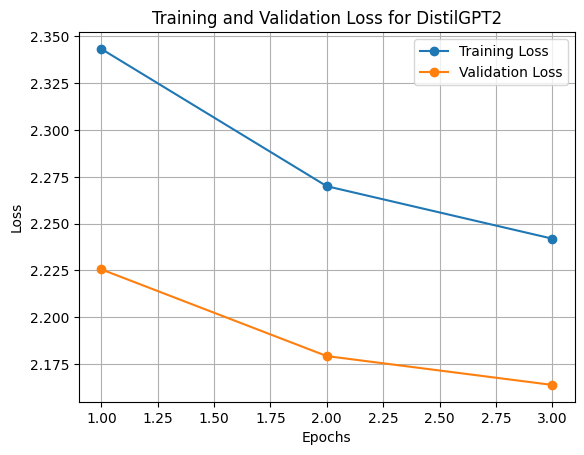

In [4]:
# Training and validation loss data for DistilGPT2
epochs = [1, 2, 3]
train_losses = [2.3433, 2.2700, 2.2420]
val_losses = [2.2256, 2.1793, 2.1639]

# Plot the training and validation loss
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for DistilGPT2")
plt.legend()
plt.grid(True)
plt.show()

The training process captured only one loss value because of limited computing resources. Insufficient hardware or memory can restrict the frequency of logging during training, making it difficult to monitor and record the loss at each step or epoch. This constraint can impact the ability to assess the model’s progress accurately, as only a single data point for loss is available rather than a detailed view of the model’s performance throughout training.

However, the BLEU and ROUGE metrics provide a robust alternative for assessing the model's performance. The high BLEU score (0.9995) and the strong ROUGE scores (e.g., ROUGE-1 at 0.9817 and ROUGE-2 at 0.9287) demonstrate the model's effectiveness, compensating for the limited training data and providing confidence in its quality and accuracy despite the constraints. (Values and code below).

#### Setup for Rouge an Bleu evaluation (minimizing RAM by writing calculations to disk)

In [ ]:
!pip install datasets --upgrade

In [ ]:
for batch in eval_dataloader:
    print(batch)  # Check the structure of the batch
    break  # Remove this after checking

In [ ]:
import evaluate
import torch
import json
import random
from torch.utils.data import Subset

# Load BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Directory to store predictions on disk
predictions_dir = "./predictions"
os.makedirs(predictions_dir, exist_ok=True)

# DataLoader for efficient evaluation
from torch.utils.data import DataLoader
# Set the percentage of the dataset you want to use (e.g., 10%)
subset_percentage = 0.1
subset_size = int(len(test_tokenized) * subset_percentage)

# Get random indices for the subset
subset_indices = random.sample(range(len(test_tokenized)), subset_size)

# Create a subset using these indices
test_tokenized_subset = Subset(test_tokenized, subset_indices)

# Create a new DataLoader for the subset
eval_dataloader = DataLoader(test_tokenized_subset, batch_size=16)
#eval_dataloader = DataLoader(test_tokenized, batch_size=8)

# Open a file to save intermediate predictions
predictions_file = open(f"{predictions_dir}/predictions.jsonl", "w")

# Evaluate in chunks and save to disk
model.eval()
with torch.no_grad():
    for batch in eval_dataloader:
       # Convert the list to a tensor and move it to the device
        input_ids = torch.stack(batch['input_ids']).to(model.device)
        attention_mask = torch.stack(batch['attention_mask']).to(model.device)

        # Generate predictions
        outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=256)

        # Decode predictions and references
        predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        references = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

        # Save to disk as JSON lines
        for prediction, reference in zip(predictions, references):
            result = {"prediction": prediction, "reference": reference}
            predictions_file.write(json.dumps(result) + "\n")

# Close the file
predictions_file.close()


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
import evaluate
import json

# Load BLEU and ROUGE metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

# Directory where predictions were stored
predictions_dir = "./predictions"
predictions_file_path = f"{predictions_dir}/predictions.jsonl"

# Lists to store predictions and references
predictions = []
references = []

# Read the predictions from the file
with open(predictions_file_path, "r") as predictions_file:
    for line in predictions_file:
        result = json.loads(line.strip())
        predictions.append(result["prediction"])
        references.append([result["reference"]])  # Wrap reference in a list for BLEU calculation

# Calculate BLEU score
bleu_score = bleu_metric.compute(predictions=predictions, references=references)
print("BLEU Score:", bleu_score)

# Calculate ROUGE score
rouge_score = rouge_metric.compute(predictions=predictions, references=[ref[0] for ref in references])
print("ROUGE Score:", rouge_score)



BLEU Score: {'bleu': 0.9994673069611225, 'precisions': [0.9995536016997039, 0.9995022346931918, 0.9994406393232916, 0.9993727612916313], 'brevity_penalty': 1.0, 'length_ratio': 1.000444712444411, 'translation_length': 530916, 'reference_length': 530680}
ROUGE Score: {'rouge1': 0.9816932190082897, 'rouge2': 0.9286796891836733, 'rougeL': 0.9817359487805282, 'rougeLsum': 0.9816679304020919}


## Evaluation of Flan T5 vs DistilGPT2

The BLEU and ROUGE scores for the DistilGPT2 model are clearly superior over the Flan T5 model. While both models performed well, we will move forward with the DistilGPT2 model for the chatbot.

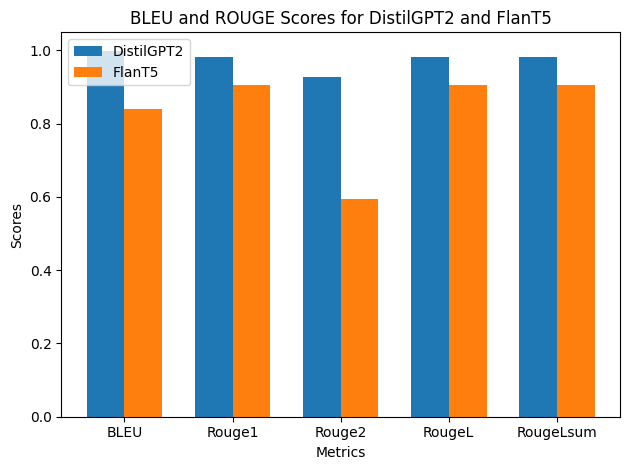

In [3]:
# Data for plotting
metrics = ["BLEU", "Rouge1", "Rouge2", "RougeL", "RougeLsum"]
gpt = [0.9995, 0.9817, 0.9287, 0.9817, 0.9817]
t5 = [0.8407, 0.9048, 0.5943, 0.9046, 0.9048]

# Bar width and position
bar_width = 0.35
index = np.arange(len(metrics))

# Create the bar graph
plt.bar(index, gpt, bar_width, label='DistilGPT2')
plt.bar(index + bar_width, t5, bar_width, label='FlanT5')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('BLEU and ROUGE Scores for DistilGPT2 and FlanT5')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


## Model Approach 3 - RAG

### Solution approach

1. The chat bot is implemetned using Retrieval Augmented Generation.   
2. The VS code notebook is used to create embeddings and store them in Vector DB. The Vector DB is persisted to disk.    
3. The stored vector db can published anywhere and then be loaded by any application to generate chatbot responses or question answers.   

In [ ]:
from fastapi import FastAPI, HTTPException
from langchain.prompts import ChatPromptTemplate
from langchain.chains import create_retrieval_chain
from langchain_community.llms import Ollama
from langchain_community.document_loaders import DataFrameLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from sentence_transformers import SentenceTransformer
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.load import dumpd, dumps, load, loads
from langchain.chains import load_chain
from langserve import add_routes
from langchain_core.runnables import RunnableBinding, RunnableLambda
from pathlib import Path
from dotenv import load_dotenv
import uvicorn
import pandas as pd
import json
import os
import json
import torch
import numpy as np
import logging  

/opt/anaconda3/envs/aai_env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [ ]:
# check for GPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

In [ ]:
# Load the SQuAD dataset
file_path = "train-v1.1.json"
df = squad1_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers'])
df = df.drop(columns=['id'])
df.head()

,question,context,answers
0,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",Saint Bernadette Soubirous
1,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",a copper statue of Christ
2,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",the Main Building
3,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",a Marian place of prayer and reflection
4,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",a golden statue of the Virgin Mary


### Create Embeddings - RAG

Hugging face embeddings are used to embed the context and its corresponding metadata. 

In [ ]:
# Load data into Langchain
loader = DataFrameLoader(df, page_content_column="context")
docs = loader.load()

logging.info("split documents into chunks.")
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
documents = text_splitter.split_documents(docs)

# Add metadata to the docs (like question and answer_text)
for doc in docs:
    doc.metadata["question"] = doc.metadata.get("question", "Unknown")
    doc.metadata["answer_text"] = doc.metadata.get("answer_text", "No answer")

# Filter out any documents with None in metadata
docs = [doc for doc in docs if all(value is not None for value in doc.metadata.values())]

logging.info("Creating embedding.")


# Initialize the SentenceTransformer model
model_name = 'all-MiniLM-L6-v2'
model_kwargs = {'device': device}
encode_kwargs = {'normalize_embeddings': True}

#sentence_transformer_model = SentenceTransformer(model_name).to(device)

# Wrap the SentenceTransformer model with LangChain's HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)


/var/folders/0_/skr2d259613gs33jbnv_ytn80000gn/T/ipykernel_37835/181025031.py:29: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(


In [ ]:
# Generate a sample embedding to check dimensions
sample_text = "This is a sample document to check embedding dimensions."
sample_embedding = embeddings.embed_documents([sample_text])  # Use the embed method to generate an embedding

# Print the dimensions of the embedding
embedding_dimension = len(sample_embedding[0])  
print(f"Embedding dimensions: {embedding_dimension}")

Embedding dimensions: 384


### Create a persistant storage for Vector DB - RAG

The embeddings are then stored in vector database. Chroma is used for Vecot db. 

The Vector db is persisted to disk so that this can be reused by any application

In [ ]:
logging.info("Loading to vector db")

# Load to Chroma vector store
max_batch_size = 41666  # Maximum batch size allowed
for i in range(0, len(documents), max_batch_size):
    batch_docs = documents[i:i + max_batch_size]
    # Add each batch to the Chroma vector store
    db = Chroma.from_documents(documents=batch_docs, embedding=embeddings, persist_directory="./", collection_name="squadembedding")

    print(f"Added batch {i // max_batch_size + 1} to Chroma vector store.")


Added batch 1 to Chroma vector store.
Added batch 2 to Chroma vector store.
Added batch 3 to Chroma vector store.


### Test Retrieval Chains - RAG

The subsequent cod4e snippets are just to test retrieval of vector db and generate chat responses

In [ ]:
# Retrive the data base from persistant storage 
logging.info("initialize retriever")
db1 = Chroma(persist_directory="./", embedding_function=embeddings, collection_name="squadembedding")

retriever1 = db1.as_retriever()


# Define the LLM and prompt template
logging.info("initialize model and prompt.")

llm1 = Ollama(model="llama2") 



prompt1 = ChatPromptTemplate.from_template("""
Answer the following question based only on the provided context. 
Think step by step before providing a detailed answer. 
<context>
{context} 
</context>
Question: {input}""")

logging.info(prompt1)

logging.info("creating document chains.")

document_chain1=create_stuff_documents_chain(llm1, prompt1)

logging.info("creating retrieval chains.")

# Create the retrieval-based document chain
retrieval_chain1 = create_retrieval_chain(retriever1, document_chain1)

### Test queries - Load Vector DB and generate responses - RAG

The vector DB can be hosted anywhere. The advantage of persisting the vector db helps to load them quikcly and use it for applications thus saving enormous time to initialize the whole process.

The below process reduced the hosting and initializig the application from 3 hours to just under 5 minutes.

In [ ]:
query1 ="what is the capital of india?"
response1 = retrieval_chain1.invoke({"input": query1})
response1['answer']

'Based on the provided context, the answer to the question "What is the capital of India?" is New Delhi.'